# Orquestación de contenedores con Kubernetes – Parte II
**En el capítulo anterior, cubrimos Kubernetes y por qué lo necesitamos, y luego discutimos cómo arrancar un clúster de Kubernetes usando minikube y KinD.** 

- Luego analizamos el recurso Pod y discutimos cómo crear y administrar Pods, cómo solucionarlos y cómo garantizar la confiabilidad de su aplicación mediante sondas, junto con patrones de diseño de contenedores múltiples para apreciar por qué Kubernetes usa Pods en primer lugar en lugar de contenedores. 
- También analizamos Secrets y ConfigMaps.

Ahora, profundizaremos en los aspectos avanzados de Kubernetes y las mejores prácticas de la línea de comandos de Kubernetes.

- Despliegues de Kubernetes
- Servicios e ingresos de Kubernetes
- Escalado automático de pods horizontales
- Gestión de aplicaciones con estado
- Mejores prácticas, consejos y trucos de la línea de comandos de Kubernetes

## Requerimientos técnicos

**Activaremos un clúster de Kubernetes basado en la nube, Google Kubernetes Engine (GKE), para los ejercicios.** 

Esto se debe a que no podrán activar balanceadores de carga y volúmenes persistentes dentro de su sistema local y, por lo tanto, no podemos usar KinD y minikube en este capítulo. 

Actualmente, Google Cloud Platform ofrece una prueba gratuita de $ 300 durante 90 días, por lo que pueden continuar y registrarse para obtener una en https://console.cloud.google.com/ .

## Puesta en marcha de Google Kubernetes Engine
Una vez que se haya registrado e iniciado sesión en su consola, puede abrir la CLI de Google Cloud Shell para ejecutar los comandos.

**01 | Necesitas habilitar la API de Kubernetes Engine primero.**


In [ ]:

$ gcloud services enable container.googleapis.com


**02 | Para crear un clúster de GKE de tres nodos.**



In [ ]:

$ gcloud container clusters create cluster-1 --zone \
us-central1-a

Creating cluster cluster-1 in us-central1-a... Cluster is being health-checked (master is healthy)...done.
Created [https://container.googleapis.com/v1/projects/<project-id>/zones/us-central1-a/clusters/cluster-1].
To inspect the contents of your cluster, go to: https://console.cloud.google.com/kubernetes/workload_/gcloud/us-central1-a/cluster-1?project=<project-id>
kubeconfig entry generated for cluster-1.
NAME       LOCATION       MASTER_VERSION    MASTER_IP       MACHINE_TYPE   NODE_VERSION      NUM_NODES  STATUS
cluster-1  us-central1-a  1.16.15-gke.4901  35.225.159.183  n1-standard-1  1.16.15-gke.4901  3          RUNNING



¡Y eso es! El clúster está en funcionamiento.

También deberá clonar el siguiente repositorio de GitHub para algunos de los ejercicios: https://github.com/Icogerard/devops.





**Ahora, comencemos con las implementaciones en la siguiente sección.**




## Despliegues de Kubernetes
**las implementaciones de aplicación de contenedor dentro de Kubernetes se realizan a través de recursos Deployment.** 

Los recursos **Deployment** emplean recursos de **ReplicaSet** detrás de escena, por lo que sería bueno ver los recursos **ReplicaSet** primero antes de pasar a comprender los recursos **Deployment**.

### Recurso de conjunto de réplicas
Los recursos **ReplicaSet** son recursos de Kubernetes que lo ayudan a ejecutar múltiples réplicas de un **Pod** un tiempo dado y proporcionan escalabilidad horizontal para las cargas de trabajo de sus contenedores, y forma el componente básico de un conjunto de escalado horizontal para sus contenedores, que es un grupo de contenedores similares unidos para funcionar como una unidad.

- Los recursos **ReplicaSet** definen el número de réplicas de un **Pod** para ejecutar en un momento dado. 
- Luego, el controlador de Kubernetes intenta mantener las réplicas y recrea un **Pod** si falla.

Nunca debe usar recursos **ReplicaSet** por sí solo, sino que debe actuar como un backend para un recurso **Deployment**.

**Sin embargo, en aras de la comprensión, veamos un ejemplo.**

In [ ]:

$ cd ~/05\ \|\ Kubernetes/kubernetes/



**01 | El manifiesto nginx-replica-set.yaml del recurso ReplicaSet tiene el siguiente aspecto.**



In [ ]:

apiVersion: apps/v1
kind: ReplicaSet
metadata:
  name: nginx
  labels:
    app: nginx
spec:
  replicas: 3
  selector:
    matchLabels:
      app: nginx
  template:
    metadata:
      labels:
        app: nginx
    spec:
      containers:
      - name: nginx
        image: nginx
            

El manifiesto incluye **apiVersion** y **kind**, como cualquier otro recurso. También contiene una sección **metadata** que define los atributos **name** y **labels**, similar a cualquier otro recurso de Kubernetes.

**La sección spec contiene los siguientes atributos.**

- replicas
      Define el número de réplicas de los Pods que coincidieron con el selector para ejecutarse en un momento dado.
- selector
      Define la base sobre la cual el recurso **ReplicaSet** incluirá **Pods** en él.
- selector.matchLabels
      Esta sección define las etiquetas y sus valores para seleccionar los Pods. Por lo tanto, el recurso **ReplicaSet** seleccionará cualquiera **Pod** con la etiqueta **app:nginx.**
- template
      Esta es una sección opcional que puede usar para definir la plantilla **Pod**. El contenido de esta sección es muy similar a la definición de un **Pod**, excepto que carece del atributo de nombre, ya que el recurso **ReplicaSet** generará nombres dinámicos para los **Pods**.

**02 | Avancemos y apliquemos este manifiesto para ver qué obtenemos.**



In [ ]:

$ kubectl apply -f nginx-replica-set.yaml



**03 | Ahora, ejecutemos lo siguiente para enumerar los recursos ReplicaSet.**


In [ ]:

$ kubectl get replicaset

NAME    DESIRED   CURRENT   READY   AGE
nginx   3         3         0       9s


Bien, entonces vemos que hay tres réplicas deseadas. Actualmente, se están ejecutando tres réplicas, pero 0 están listas.

**04 | Esperemos un momento y luego volvamos a ejecutar el comando**

In [ ]:

$ kubectl get replicaset

NAME    DESIRED   CURRENT   READY   AGE
nginx   3         3         3       1m10s


Y ahora vemos tres pods listos que están esperando una conexión. 

**05 | Ahora, enumeremos los Pods y veamos qué ha hecho el recurso ReplicaSet detrás de escena**

In [ ]:

$ kubectl get pod
NAME          READY   STATUS    RESTARTS   AGE
nginx-6qr9j   1/1     Running   0          1m32s
nginx-7hkqv   1/1     Running   0          1m32s
nginx-9kvkj   1/1     Running   0          1m32s


Hay tres **Pods nginx**, y cada uno tiene un nombre que comienza **nginx** pero termina con un hash aleatorio. 

Bueno, el recurso ReplicaSet agregó un hash aleatorio al final del nombre del recurso **ReplicaSet** para generar Pods únicos. 

Sí, el nombre de cada recurso de un tipo particular en Kubernetes debe ser único.

**06 | Avancemos y usemos el siguiente comando para eliminar uno de los pods del recurso ReplicaSet y veamos qué obtenemos.**



$ kubectl delete pod nginx-9kvkj && kubectl get pod
pod "nginx-9kvkj" deleted

NAME          READY   STATUS    RESTARTS   AGE
nginx-6qr9j   1/1     Running   0          8m34s
nginx-7hkqv   1/1     Running   0          8m34s
nginx-9xbdf   1/1     Running   0          5s


Y vemos que aunque eliminamos el **Pod nginx-9kvkj**, el recurso **ReplicaSet** lo ha reemplazado por un nuevo **Pod nginx-9xbdf**. Así funcionan los recursos **ReplicaSet**.

Puede eliminar un recurso **ReplicaSet** como cualquier otro recurso de Kubernetes. 
- Puede ejecutar el comando kubectl delete replicaset < ReplicaSet name > para un enfoque imperativo 
- O usar kubectl delete -f < manifest_file > para un enfoque declarativo.

**07 | Usemos el enfoque anterior y eliminemos el recurso ReplicaSet.**

In [ ]:

$ kubectl delete replicaset nginx


In [ ]:
# Verificamos y los pods se estan finalizando

$ kubectl get pod

NAME          READY   STATUS        RESTARTS   AGE
nginx-j547c   1/1     Terminating   0          3m37s
nginx-vd6ff   1/1     Terminating   0          2m3s
nginx-w4n9t   1/1     Terminating   0          3m37s


**08 | Verifiquemos si el ReplicaSetrecurso ha sido eliminado ejecutando.**




$ kubectl get replicaset
No resources found in default namespace.


**Y no tenemos nada en default namespace.** 
- Esto significa que el recurso ReplicaSet se ha ido.

Como discutimos, los recursos **ReplicaSet** no deben usarse por sí solos, sino que deben ser el backend de los recursos **Deployment**. 

**Veamos ahora los recursos Deployment de Kubernetes.**

### Recurso de implementación
**Los recursos Deployment de Kubernetes ayudan a administrar implementaciones para aplicaciones de contenedores.** 

- Ellos se utilizan típicamente para gestionar cargas de trabajo sin estado. 

Todavía podemos usarlos para administrar aplicaciones con estado, pero el enfoque recomendado para aplicaciones con estado es usar recursos **StatefulSet**.

Las implementaciones de Kubernetes usan el recursos **ReplicaSet** como backend y la cadena de recursos se parece al siguiente diagrama.

Cadena de despliegue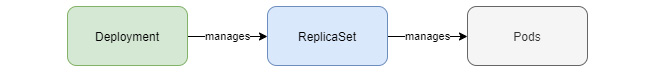

**01 | Echemos el ejemplo anterior y vamos a crear un manifiesto de recurso Deployment NGINX – nginx-deployment.yaml.**



In [ ]:

apiVersion: apps/v1
kind: Deployment
metadata:
  name: nginx
  labels:
    app: nginx
spec:
  replicas: 3
  selector:
    matchLabels:
      app: nginx
  template:
    metadata:
      labels:
        app: nginx
    spec:
      containers:
      - name: nginx
        image: nginx
            

El manifiesto es muy similar al recurso **ReplicaSet**, excepto por el atributo **kind**, que es en este caso **Deployment**.

**02 | Apliquemos el manifiesto**

In [ ]:

$ kubectl apply -f nginx-deployment.yaml


Entonces, como se ha creado el recurso **Deployment**, veamos la cadena de recursos que creó. 

**03 | Corramos kubectl get para listar el recurso Deployment**

In [ ]:

$ kubectl get deployment

NAME    READY   UP-TO-DATE   AVAILABLE   AGE
nginx   3/3     3            3           6s


Y que vemos hay un recurso **Deployment** llamado nginx, con 3/3 Pods listos y tres Pods UP-TO-DATE. 

Como este recurso Deployment puede administrar múltiples versiones, UP-TO-DATE por lo tanto significa si el último Deployment se ha implementado con éxito. También muestra tres Pods disponibles en ese momento.

**04 | Como sabemos que los recursos *Deployment* crean recursos *ReplicaSet* en segundo plano, obtengamos los recursos *ReplicaSet*.**



In [ ]:

$ kubectl get replicaset

NAME               DESIRED   CURRENT   READY   AGE
nginx-6799fc88d8   3         3         3       11s


Y vemos que el recurso Deployment ha creado un recurso ReplicaSet, que comienza con nginx y termina con un hash aleatorio. 

Eso es necesario ya que un recurso **Deployment** puede contener uno o más recursos ReplicaSet.

**05 | Los siguientes en la cadena son los Pods, así que obtengamos los recursos Pod.**

In [ ]:

$ kubectl get pod

NAME                     READY   STATUS    RESTARTS   AGE
nginx-6799fc88d8-d52mj   1/1     Running   0          15s
nginx-6799fc88d8-dmpbn   1/1     Running   0          15s
nginx-6799fc88d8-msvxw   1/1     Running   0          15s


**Y, como era de esperar, tenemos tres Pods.** 

Cada uno comienza con el nombre del recurso **ReplicaSet** y termina con un **hash aleatorio**. Es por eso que ves que hay dos hashes en el nombre del **Pod**.

Ahora vamos a suponer que tenemos una nueva versión y deseamos implementar una nueva versión de imagen de contenedor. 

**06 | Entonces, actualicemos el recurso *Deployment* con una nueva imagen y también registremos el comando en el historial de implementación.**

In [ ]:

$ kubectl set image deployment/nginx \nginx=nginx:1.16.1 --record
deployment.apps/nginx image updated


**07 | Para verificar el estado de implementación.**



In [ ]:

$ kubectl rollout status deployment nginx
deployment "nginx" successfully rolled out


**08 | Para verificar el historial de implementación.**



In [ ]:

$ kubectl rollout history deployment nginx
deployment.apps/nginx
REVISION  CHANGE-CAUSE
1         <none>
2         kubectl set image deployment/nginx nginx=nginx:1.16.1 --record=true
    

**Como podemos ver, hay dos revisiones en el historial de implementación.** 

La revisión 1 fue la implementación inicial, y la revisión 2 se debió al comando **kubectl set image** que ejecutamos, como se desprende de **CHANGE-CAUSE**. 

**09 | Ahora, supongamos que encuentra un problema después de su implementación y desea revertirlo a la versión anterior.**



In [ ]:

$ kubectl rollout undo deployment nginx
deployment.apps/nginx rolled back 


**10 | Volvamos a verificar el estado de la implementación.**



In [ ]:

$ kubectl rollout status deployment nginx
Waiting for deployment "nginx" rollout to finish: 2 out of 3 new replicas have been updated...
Waiting for deployment "nginx" rollout to finish: 1 old replicas are pending termination...
deployment "nginx" successfully rolled out


**11 | Y finalmente, vaamos a verificar el historial de implementación.**



In [ ]:

$ kubectl rollout history deployment nginx
deployment.apps/nginx
REVISION  CHANGE-CAUSE
2         kubectl set image deployment/nginx nginx=nginx:1.16.1 --record=true
3         <none>


**Y obtenemos la revisión 3 con change-cause < none >.** 

Esto se debe a que no registramos la reversión usando la bandera --record en este caso como lo hicimos en el último comando.

**Tip Pro.**

> Registre siempre las actualizaciones de implementación, ya que es más fácil echar un vistazo al historial para ver qué se implementó.

**Ahora, veamos algunas estrategias comunes de implementación de Kubernetes para entender cómo usar las implementaciones de manera efectiva.**

### Estrategias de implementación de Kubernetes
**Actualización de la implementación existente requiere que especifique una nueva imagen de contenedor.** 

Es por eso que creamos versiones de imágenes de contenedores en primer lugar para que pueda implementar y revertir los cambios de la aplicación según sea necesario. 

Como ejecutamos todo en contenedores, y los contenedores, por definición, son efímeros, esto permite una gran cantidad de estrategias de implementación diferentes que podemos implementar. 

**Hay varias estrategias de implementación, y algunas de ellas son las siguientes.**

- Recrear
      Este es elel más simple de todos. Eliminar el antiguo Pody desplegar el nuevo.
- Actualización continua
      Rodar lentamenteelimine los Pods de la nueva versión mientras aún ejecuta la versión anterior, y elimine lentamente los Pods antiguos a medida que los nuevos Pods se preparan.
- Azul/Verde
      Este es unestrategia de implementación derivada donde mantenemos ambas versiones ejecutándose simultáneamente y cambiamos el tráfico a la versión más nueva cuando queremos.
- Canarias
      Esto es aplicablea implementaciones azul/verde en las que cambiamos un porcentaje del tráfico a la versión más nueva de la aplicación antes de implementar completamente el lanzamiento.
- Pruebas A /B
      Las pruebas A/B son más una técnica para aplicar a las implementaciones Blue/Green. Esto escuando quieras implementar el más nuevoversión a un subconjunto de usuarios dispuestos y estudie los patrones de uso antes de implementar la versión más nueva en general. Con Kubernetes no obtiene pruebas A/B listas para usar, sino que debe confiar en las tecnologías de malla de servicio que se conectan bien con Kubernetes, como Istio , Linkerd y Traefik.


Kubernetes proporciona dos estrategias de implementación listas para usar: Recreatey RollingUpdate.



### Recrear
**La estrategia Recrear es la estrategia de implementación más directa.** 

Cuando actualiza la implementación con la estrategia Recreate, Kubernetes inmediatamente desactiva el recurso ReplicaSet antiguo y crea uno nuevo con la cantidad requerida de réplicas, de acuerdo con las líneas del siguiente diagrama.

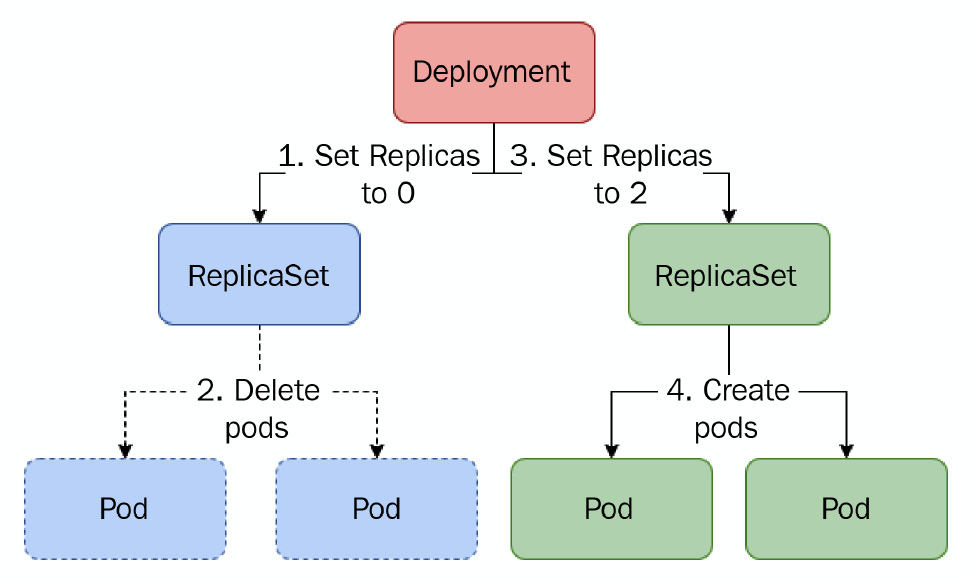

Kubernetes no elimina el recurso antiguo **ReplicaSet**, sino que simplemente lo establece replicas en 0. 
- Eso es necesario si necesitamos volver rápidamente a la nueva versión. 

Este enfoque da como resultado tiempo de inactividad y, por lo tanto, no es algo que desee usar cada vez a menos que tenga una restricción. 
- Por lo tanto, esta estrategia no es la estrategia de implementación predeterminada en Kubernetes.


> **Tip Pro.**<br>
Pueden usar la estrategia Recrear si su aplicación no admite varias réplicas, si no admite más de una cierta cantidad de réplicas, como aplicaciones que necesitan mantener un quórum, o si no admite varias versiones a la vez.

**01 | Actualicemos nginx-deployment con la estrategia Recreate. | Veamos el archivo nginx-recreate.yaml que contiene la actualización.**

In [ ]:

apiVersion: apps/v1
kind: Deployment
metadata:
  name: nginx
  labels:
    app: nginx
spec:
  replicas: 3
  selector:
    matchLabels:
      app: nginx
  strategy:
    type: Recreate
  template:
    metadata:
      labels:
        app: nginx
    spec:
      containers:
      - name: nginx
        image: nginx
            

El archivo YAML ahora contiene una sección strategy con type: Recreate.

**02 | Ahora, apliquemos el archivo nginx-recreate.yaml y observemos los recursos ReplicaSet.**



$ kubectl apply -f nginx-recreate.yaml
$ kubectl get replicaset -w
deployment.apps/nginx configured

NAME               DESIRED   CURRENT   READY   AGE
nginx-6799fc88d8   0         0         0       0s
nginx-6889dfccd5   0         3         3       7m42s
nginx-6889dfccd5   0         0         0       7m42s
nginx-6799fc88d8   3         0         0       1s
nginx-6799fc88d8   3         3         0       2s
nginx-6799fc88d8   3         3         3       6s


Como vemos, el recurso de implementación crea un nuevo recurso ReplicaSet: nginx-6799fc88d8, con el 0 deseado en réplicas.

Luego establece a 0 las réplicas deseadas en el recurso anterior ReplicaSet y espera a que el recurso ReplicaSet anterior se desaloje por completo. 
- Entonces  comienza a implementar el nuevo recurso ReplicaSet en las imágenes deseadas inmediatamente.

## Servicios e ingresos de Kubernetes
**El recurso Servicio ayuda a exponer las cargas de trabajo de Kubernetes al mundo interno o externo.** 

Como sabemos, los Pods son recursos efímeros, pueden ir y venir. A cada Pod se le asigna undirección IP y nombre de host únicos, pero una vez que el Pod desaparece, la dirección IP del Pod y el nombre de host cambian. 

Considere un escenario donde uno de tus Pods quiere interactuar con otro. Sin embargo, debido a la naturaleza transitoria, no puede configurar un punto final adecuado. Si usa la dirección IP o el nombre de host como punto final de un correo electrónico Pod y el Pod se destruye, ya no podrá conectarse a él. Por lo tanto, exponer un Pod por sí solo no es una gran idea.

**Kubernetes proporciona el recurso Service para proporcionar una dirección IP estática a un grupo de pods.** 

Además de exponer los pods en una sola dirección IP estática, también proporciona equilibrio de carga de tráfico entre pods en una configuración de turno rotativo. 
- Ayuda a distribuir el tráfico por igual entre los pods y, por lo tanto, es el método predeterminado para exponer sus cargas de trabajo.

Al recurso Service también se le asigna un nombre de dominio completamente calificado (FQDN) estático (según el nombre del servicio) y, por lo tanto, para que sus puntos finales sean a prueba de fallas, puden usar el Service FQDN del recurso en lugar de la dirección IP dentro de su clúster.

Ahora, volviendo a ver los recursos de Service, hay múltiples tipos de recursos Service: **ClusterIP , NodePort y LoadBalancer,** cada uno con sus respectivos casos de uso.

Servicios de Kubernetes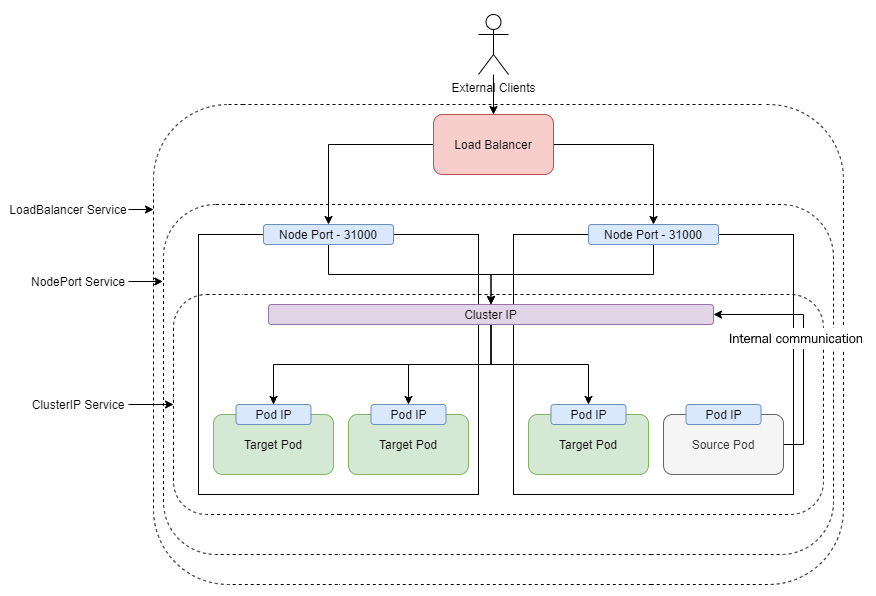

### Servicios IP de clúster
ClusterIP Servicelos recursos exponen pods dentro del clúster de Kubernetes y son los predeterminados si no especifica un tipo. No es posiblepara acceder a los ClusterIP Servicerecursosfuera del clúster y, por lo tanto, nunca se usa para exponer sus Pods al mundo exterior. ClusterIP Servicelos recursos generalmente se usan para exponer aplicaciones de back-end, como almacenes de datos y bases de datos, especialmente la capa comercial y la capa de datos en una arquitectura de tres capas.


> **Tip Pro.** <br> Al elegir entre los tipos de recursos del servicio, como regla general, siempre comience con el recurso del servicio ClusterIP y cámbielo si lo necesita más adelante. Esto asegurará que la menor cantidad de sus cargas de trabajo estén expuestas externamente.


Primero creemos un recurso de implementación de redis usando el método imperativo usando el siguiente comando:



In [ ]:

$ kubectl create deployment redis --image=redis
deployment.apps/redis created


Compruebe si la implementación se ha llevado a cabo correctamente con el siguiente comando:

In [ ]:

$ kubectl rollout status deployment redis
deployment "redis" successfully rolled out


A medida que la implementación se implementa correctamente, intentemos exponer el pod en un recurso del servicio ClusterIP. Para acceder a los recursos de esta sección, haga un cd en lo siguiente:

In [ ]:
$ cd ~/modern-devops/ch5/services/ 



In [ ]:
Veamos primero el manifiesto de recursos del servicio, redis-clusterip.yaml:

In [ ]:

apiVersion: v1
kind: Service
metadata:
  labels:
    app: redis
  name: redis
spec:
  ports:
  - port: 6379
    protocol: TCP
    targetPort: 6379
  selector:
    app: redis
        

El manifiesto del recurso del servicio comienza con apiVersion y es del mismo tipo que cualquier otro manifiesto. Tiene una sección de metadatos que contiene el nombre y las etiquetas.

La sección de especificaciones contiene lo siguiente:

- puertos: esta sección incluye una lista de puertos que queremos exponer a través del recurso de servicio: 
        A. puerto: El puerto que deseamos exponer.
        B. protocol: El protocolo del puerto que estamos exponiendo (TCP/UDP).
        C. targetPort: el puerto del contenedor de destino donde el puerto expuesto reenviará la conexión. Esto nos permite tener un mapeo de puertos similar a Docker.
- Selector: esta sección contiene etiquetas según las cuales se selecciona el grupo de pods.


Apliquemos el manifiesto de recursos del servicio usando el siguiente comando y veamos qué obtenemos:
    

In [ ]:

$ kubectl apply -f redis-clusterip.yaml


Ejecutemos kubectl get para enumerar el recurso del servicio y obtener la IP del clúster:

In [ ]:

$ kubectl get service redis

NAME    TYPE        CLUSTER-IP     EXTERNAL-IP   PORT(S)    AGE
redis   ClusterIP   10.96.118.99   <none>        6379/TCP   8s


Y vemos un recurso de servicio redis ejecutándose con un ClusterIP. Pero como este Pod no está expuesto externamente, la única forma de acceder a él es a través de un segundo Pod que se ejecuta dentro del clúster.

Vamos a crear un pod de busybox en modo interactivo para inspeccionar el recurso del servicio y ejecutar algunas pruebas con el siguiente comando:

In [ ]:

$ kubectl run busybox --rm --restart Never -it --image=busybox
/ # 


Y con esto, vemos un aviso. Esto significa que hemos lanzado el contenedor busybox y actualmente estamos dentro de él. Usaremos la aplicación telnet para verificar la conectividad entre Pods.

Hagamos telnet con la IP y el puerto del clúster para ver si es accesible con el siguiente comando:

In [ ]:

/ # telnet 10.96.118.99 6379
Connected to 10.96.118.99


El par IP/puerto es accesible desde allí. Kubernetes también proporciona un DNS interno para promover el descubrimiento de servicios y conectarse al recurso del servicio. Podemos hacer un nslookup inverso en la IP del clúster para obtener el nombre de dominio completo del recurso del servicio usando el siguiente comando:

In [ ]:

/ # nslookup 10.96.118.99
Server:         10.96.0.10
Address:        10.96.0.10:53
99.118.96.10.in-addr.arpa       name = redis.default.svc.cluster.local


Y como vemos, se puede acceder a la dirección IP desde el FQDN: redis.default.svc.cluster.local. Podemos utilizar todo el dominio o partes de él en función de dónde nos ubiquemos. El FQDN está formado por estas partes: <nombre_servicio>.<espacio de nombres>.svc.<dominio-clúster>.local.

Kubernetes usa espacios de nombres para segregar recursos. Puede visualizar los espacios de nombres como múltiples clústeres virtuales que existen dentro del mismo clúster físico de Kubernetes. Puede usarlos si tiene muchos usuarios trabajando en varios equipos o proyectos. Hemos estado trabajando en el espacio de nombres predeterminado hasta ahora y continuaremos haciéndolo. Si su pod de origen se encuentra en el mismo espacio de nombres que el recurso del servicio, simplemente puede usar service_name para conectarse a su recurso del servicio, algo como el siguiente ejemplo:

In [ ]:

/ # telnet redis 6379
Connected to redis


Si desea llamar a un recurso de servicio desde un pod situado en un espacio de nombres diferente, puede usar < service_name >.< namespace > en su lugar, algo como el siguiente ejemplo:

In [ ]:

/ # telnet redis.default 6379
Connected to redis.default


Algunas mallas de servicios, como Istio, permiten la comunicación entre varios clústeres. En esa situación, también puede usar el nombre del clúster para conectarse al recurso del servicio, pero como se trata de un tema avanzado, está fuera del alcance de esta discusión.

> **Tip Pro.** <br> Utilice siempre el nombre de dominio más corto posible para los puntos finales, ya que permite una mayor flexibilidad para mover sus recursos de Kubernetes entre sus entornos.

Los servicios de ClusterIP funcionan muy bien para exponer recursos de servicio internos, pero ¿qué pasa si queremos exponer nuestro recurso de servicio al mundo externo? Echemos un vistazo al recurso del servicio NodePort para eso.

## Servicios de NodePort
Los recursos del servicio NodePort se utilizan para exponer sus pods al mundo exterior. Cuando crea un recurso de servicio NodePort, activa un recurso de servicio ClusterIP y asigna el puerto ClusterIP a un número de puerto alto aleatorio (predeterminado: 30000-32767) en todos los nodos del clúster. También puede especificar un número de NodePort estático si así lo desea. Entonces, con un recurso del Servicio NodePort, puede acceder a sus Pods usando la dirección IP de cualquier nodo dentro de su clúster y el NodePort.

> **Tip Pro.** <br> Aunque es posible especificar un número de NodePort estático, debe evitar usarlo. Esto se debe a que podría terminar en conflictos de puertos con otros recursos del Servicio y depender mucho de la configuración y la gestión de cambios. En cambio, mantenga las cosas simples y use puertos dinámicos.

Siguiendo el ejemplo de la aplicación Flask, creemos el Pod de la aplicación Flask con el recurso Redis Service que creamos antes, actuando como su backend, y luego expondremos el Pod en NodePort.

Use el siguiente comando para crear un Pod de manera imperativa:

In [ ]:

$ kubectl run flask-app --image=<your_dockerhub_user>\
/python-flask-redis


Ahora, como hemos creado el pod de la aplicación de matraz, verifiquemos su estado con el siguiente comando:

In [ ]:

$ kubectl get pod flask-app
NAME        READY   STATUS    RESTARTS   AGE
flask-app   1/1     Running   0          19s


El pod de la aplicación de matraz se está ejecutando correctamente y está listo para aceptar solicitudes. Es hora de comprender el manifiesto de recursos para el servicio NodePort, Flash-nodeport.yaml:

In [ ]:

apiVersion: v1
kind: Service
metadata:
  labels:
    run: flask-app
  name: flask-app
spec:
  ports:
  - port: 5000
    protocol: TCP
    targetPort: 5000
  selector:
    run: flask-app
  type: NodePort
    

El manifiesto es muy similar al manifiesto de ClusterIP, pero también contiene un atributo de tipo que especifica el tipo de recurso del servicio: NodePort en este caso.

Apliquemos este manifiesto para ver qué obtenemos usando el siguiente comando:

In [ ]:

$ kubectl apply -f flask-nodeport.yaml


Ahora, enumeremos el recurso de servicio para obtener NodePort usando el siguiente comando:

In [ ]:

$ kubectl get service flask-app
NAME        TYPE       CLUSTER-IP     EXTERNAL-IP   PORT(S)          AGE
flask-app   NodePort   10.3.240.246   <none>        5000:32618/TCP   9s
    

Y vemos que el tipo ahora es NodePort, y que el puerto de contenedor 5000 está asignado al puerto de nodo 32618.

Ahora, si está dentro del clúster de Kubernetes, puede acceder al recurso del servicio mediante localhost:32618. Pero como usamos Google Cloud Shell, necesitamos acceder a un nodo de Kubernetes para acceder al recurso del Servicio.

Enumeremos primero los nodos usando el siguiente comando:

In [ ]:

$ kubectl get nodes

NAME                                       STATUS   ROLES    AGE   VERSION
gke-cluster-1-default-pool-c30a0b48-1dhh   Ready    <none>   17m   v1.16.15-gke.4901
gke-cluster-1-default-pool-c30a0b48-7lhl   Ready    <none>   17m   v1.16.15-gke.4901
gke-cluster-1-default-pool-c30a0b48-zwg1   Ready    <none>   17m   v1.16.15-gke.4901


Y como vemos, tenemos tres nodos. Ingresemos al nodo gke-cluster-1-default-pool-c30a0b48-1dhh usando el siguiente comando:

In [ ]:

$ gcloud compute ssh gke-cluster-1-default-pool-c30a0b48-1dhh


Ahora, como estamos dentro del nodo gke-cluster-1-default-pool-c30a0b48-1dhh, vamos a curl localhost:32618 usando el siguiente comando:

In [ ]:

$ curl localhost:32618
Hi there! This page was last visited on 2020-12-30, 08:32:25.
        

¡Y recibimos una respuesta! Puede acceder a cualquier nodo y curvar el punto final y debería obtener una respuesta similar.

Para salir del nodo y volver al indicador de Cloud Shell, ejecute el siguiente comando:

In [ ]:

$ exit
Connection to 35.202.82.74 closed.


Y estás de vuelta en el aviso de Cloud Shell.

> **Tip Pro.** <br> Los servicios de NodePort son un tipo de recurso intermedio. Esto significa que, si bien constituye un componente esencial de la prestación de servicios externos, no se utiliza por sí solo la mayor parte del tiempo. Cuando se ejecuta en la nube, puede usar los recursos del servicio LoadBalancer en su lugar. Incluso para una configuración local, tiene sentido no usar NodePort para cada recurso de servicio y, en su lugar, usar recursos de ingreso.

Ahora, echemos un vistazo al recurso del servicio LoadBalancer que se usa ampliamente para exponer sus cargas de trabajo de Kubernetes de forma externa.

## Servicios de equilibrador de carga
Los recursos del servicio LoadBalancer ayudan a exponer sus pods en un único punto final con equilibrio de carga. Estos recursos de Servicio solo se pueden usar dentro de plataformas en la nube y plataformas que brindan a los controladores de Kubernetes acceso para activar recursos de red externos. Un servicio LoadBalancer prácticamente activa un recurso del servicio NodePort y luego solicita a la API de la nube que active un equilibrador de carga frente a los puertos del nodo. De esa forma, proporciona un punto final único para acceder a su recurso de servicio desde el mundo exterior.

Activar un recurso del servicio LoadBalancer es simple: solo configure el tipo en LoadBalancer.

Expongamos la aplicación Flask como un balanceador de carga usando el siguiente manifiesto: Flask-loadbalancer.yaml:

In [ ]:

...
spec:
  ports:
  - port: 5000
    protocol: TCP
    targetPort: 5000
  selector:
    run: flask-app
  type: LoadBalancer
    

Ahora, apliquemos el manifiesto usando el siguiente comando:

In [ ]:

$ kubectl apply -f flask-loadbalancer.yaml


Y hagamos que el recurso del Servicio note los cambios usando el siguiente comando:

In [ ]:

$ kubectl get svc flask-app
NAME        TYPE           CLUSTER-IP     EXTERNAL-IP   PORT(S)          AGE
flask-app   LoadBalancer   10.3.240.246   34.71.95.96   5000:32618/TCP   17m
    

Y el tipo de recurso del servicio ahora es LoadBalancer. Como puede ver, ahora contiene una IP externa junto con la IP del clúster.

A continuación, puede activar la IP externa en el puerto 5000 con el siguiente comando:

In [ ]:

$ curl 34.71.95.96:5000
Hi there! This page was last visited on 2020-12-30, 08:32:25.
        

Y obtienes la misma respuesta que antes. Su recurso de servicio ahora se ejecuta externamente.

> **Tip Pro.** <br> Los recursos del servicio LoadBalancer tienden a ser costosos, ya que cada nuevo recurso genera un balanceador de carga de red dentro de su nube. Si tiene cargas de trabajo basadas en HTTP, debe usar el recurso Ingress en lugar de LoadBalancer para ahorrar en costos de recursos y optimizar el tráfico.

Si bien los servicios de Kubernetes forman el bloque de construcción básico para exponer sus aplicaciones de contenedores interna y externamente, Kubernetes también proporciona recursos de Ingress para un control detallado adicional sobre el tráfico. Echemos un vistazo a esto en la siguiente sección.

## Recursos de ingreso
Los recursos de ingreso actúan como proxies inversos en Kubernetes. No necesita un balanceador de carga para cada aplicación que ejecuta dentro de su patrimonio. Los balanceadores de carga normalmente solo reenvían el tráfico y no requieren una gran potencia informática. Por lo tanto, no tiene sentido activar un balanceador de carga para todo.

Por lo tanto, Kubernetes proporciona una forma de enrutar el tráfico externo a su clúster a través de los recursos de Ingress. Estos recursos lo ayudan a subdividir el tráfico según múltiples condiciones. Algunos de estos son los siguientes:

- Basado en la ruta de URL
- Basado en el nombre de host
- Una combinación de los dos

El siguiente diagrama ilustra cómo funcionan los recursos de Ingress:

## Descripción de los comandos del contenedor de Docker
Antes de sumergirnos en elComandos Docker más complejos, repasemos y entremos un poco más en detalle en los comandos que hemos usado en capítulos anteriores.



In [ ]:

$ docker container run hello-world


Como recordará, este comando extrae una 1.84imagen KB de Docker Hub. Puede encontrar la página de Docker Hub para la imagen en https://hub.docker.com/images/hello-world/ y, según lo siguiente Dockerfile, ejecuta un ejecutable llamadohello:

In [ ]:

FROM scratch
COPY hello /
CMD ["/hello"]


El ejecutable hello imprime el texto Hello from Docker! en la Terminal y luego el proceso finaliza. 

Como puede ver en el texto completo del mensaje en la siguiente salida de Terminal, el binario hello también le permite saber exactamente qué pasos acaban de ocurrir:

A medida que finaliza el proceso, nuestroEl contenedor también se detiene. Esto se puede ver ejecutando el siguiente comando:



In [ ]:

$ docker container ls -a


Puede notar en la salida de la Terminal que primero ejecuté docker container lscon y sin la -abandera. Esta es una abreviatura de --all, ya que ejecutarlo sin la bandera no muestra ningún contenedor cerrado.

Es posible que haya notado que no tuvimos que nombrar nuestro contenedor. Esto se debe a que no iba a existir el tiempo suficiente para que nos importara cómo se llamaba. Sin embargo, Docker asigna automáticamente nombres a los contenedores y, en mi caso, puede ver que se llamó awesome_jackson.

Notará a lo largo de su uso de Docker que presenta algunos nombres realmente interesantes para sus contenedores si decide dejar que los genere por usted. Creó el nombrede una lista de palabras para la palabra de la izquierda, y para la palabra de la derecha, de los nombres de científicos y piratas informáticos notables. Aunque esto está un poco fuera de tema, el código para generar los nombres se puede encontrar en names-generator.go. Justo al final del código fuente, tiene la siguiente ifdeclaración:

In [ ]:

if name == "boring_wozniak" /* Steve Wozniak is not boring */ { goto begin }


Esto significa que nunca habrá un contenedor llamado bored_wozniak (y con mucha razón también).

### Información:

Steve Wozniak es un inventor, ingeniero electrónico, programador y empresario que cofundó Apple Inc. con Steve Jobs. Es conocido como un pionero de la revolución de las computadoras personales de los años 70 y 80, ¡y definitivamente no es aburrido!

Podemos eliminar el contenedor con un estado de exitedejecutando el siguiente comando, asegurándonos de reemplazar el nombre del contenedor con su propio nombre de contenedor:

In [ ]:

$ docker container rm awesome_jackson


Antes, lanzamos un contenedor usando la imagen oficial de NGINX usando el siguiente comando:



In [ ]:

$ docker container run -d --name nginx-test -p 8080:80 nginx


    

Como recordará, esto descarga la imagen y la ejecuta, mapeando el puerto 8080en nuestra máquina hostpara portar 80en el contenedor, y lo llama nginx-test:

Como puede ver, ejecutar la imagen de Docker lsnos muestra que ahora tenemos dos imágenes descargadas y también en ejecución. El siguiente comando nos muestra que tenemos un contenedor en ejecución:



In [ ]:

$ docker container ls


El siguiente resultado de la Terminal muestra que el mío había estado activo durante 5 minutos cuando ejecuté el comando:

Como puede ver en nuestro docker container runcomando, introdujimos tres banderas. Uno de ellos fue -d, que es la abreviatura de --detach. Si no hubiéramos agregado este indicador, nuestro contenedor se habría ejecutado en primer plano, lo que significa que nuestra Terminal se habría congelado hasta que le pasáramos al proceso un comando de escape presionando Ctrl + C.

Podemos ver esto en acción ejecutando el siguiente comando para lanzar un segundo contenedor NGINX para ejecutar junto con el contenedor que ya lanzamos:



In [ ]:

$ docker container run --name nginx-foreground -p 9090:80 nginx
    

Una vez iniciado, abra unnavegador e ingrese http://localhost:9090/. A medida que carga la página, notará que su visita a la página se imprime en la pantalla. Al presionar Actualizar en su navegador, se mostrarán más resultados, hasta que presione Ctrl + C nuevamente en la Terminal:



La ejecución docker container ls -amuestra que tiene dos contenedores, uno de los cuales ha salido:

¿Entonces qué pasó? Cuando eliminamos la detachbandera, Docker nos conectó al proceso NGINX directamente dentro del contenedor, lo que significa que teníamos visibilidad de stdin , stdout y stderr para ese proceso. Cuando usamos Ctrl + C , en realidad enviamos una instrucción al proceso NGINX para terminarlo. Como ese era el proceso que mantenía a nuestrocontenedor en ejecución, el contenedor salió inmediatamente una vez que ya no había un proceso en ejecución.

### Nota IMPORTANTE

La entrada estándar ( stdin ) es el identificador que lee nuestro proceso para obtener información del usuario final. La salida estándar ( stdout ) es donde el proceso escribe información normal. El error estándar ( stderr ) es donde el proceso escribe mensajes de error.

Otrocosate habrás dado cuenta cuandolanzamos el nginx-foregroundcontenedor es que le dimos un nombre diferente usando la --namebandera.

Esto se debe a que no puede tener dos contenedores con el mismo nombre, ya que Docker le brinda la opción de interactuar con sus contenedores usando ambos CONTAINER ID or NAMEvalores. Esta es la razón por la que existe la función de generador de nombres: para asignar un nombre aleatorio a los contenedores que no desea nombrar usted mismo, y también para asegurarse de que nunca llamemos aburrido a Steve Wozniak.

Lo último a mencionar es que cuando lanzamos nginx-foreground, le pedimos a Docker que mapeara puerto 9090a puerto 80en el contenedor. Esto se debió a que no podemos asignar más de un proceso a un puerto en una máquina host, por lo que si intentamos iniciar nuestro segundo contenedor con el mismo puerto que el primero, habríamos recibido un mensaje de error:




docker: Error response from daemon: driver failed programming external connectivity on endpoint nginx-foreground (3f5b355607f24e03f09a60ee688645f223bafe4492f807459e4a 2b83571f23f4): Bind for 0.0.0.0:8080 failed: port is already allocated.
                    

Además, dado que estamos ejecutando el contenedor en primer plano, es posible que reciba un error del proceso NGINX, ya que no pudo iniciarse:



In [ ]:

ERRO[0003] error getting events from daemon: net/http: request cancelled
        

Sin embargo, también puede notar que estamos mapeando el puerto 80en el contenedor, ¿por qué no hay error allí?

Los contenedores en sí mismos son recursos aislados, lo que significa que podemos lanzar tantos contenedores como queramos con el puerto 80reasignado, ynunca chocarán con otros contenedores; solo tenemos problemas cuando queremos enrutarnos al puerto del contenedor expuesto desde nuestro host Docker.

Mantengamos nuestro contenedor NGINX en ejecución para la siguiente sección, donde exploraremos más formas de interactuar con el contenedor.

## Interactuando con sus contenedores
Hasta ahora, nuestros contenedoreshan estado ejecutando un solo proceso. Docker le proporciona algunas herramientas que le permiten bifurcar procesos adicionales e interactuar con ellos, y cubriremos esas herramientas en las siguientes secciones:

